<a href="https://colab.research.google.com/github/DiNOV-Tokyo/yolov5/blob/main/NaviTabi_ResNet101_TL_Inagi_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.ResNet101で転移学習・推論

参考にしたサイト# https://tetsumag.com/2021/01/11/ml7/



## 1.1 Google Drive をマウント

In [ ]:
!cd /home/developer/dev

In [ ]:
!mkdir test_dir

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks
#%mkdir yolo_train
%cd yolo_train

/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/yolo_train


## 1.2 モジュール読み込み

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
from tqdm import tqdm
from PIL import Image

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.10.0+cu111 CPU


## 1.3 各種準備

In [4]:
# transformsを定義
size = (224, 224)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
!ls -al ./dev/dataset

total 12
drwxr-xr-x  3 root   root 4096 Aug 25 08:03 .
drwxr-xr-x 14 jovyan 1000 4096 Sep 11 20:52 ..
drwxr-xr-x  3 root   root 4096 Aug 25 08:09 CIFAR10


In [5]:
# datasetsを定義
train_data_dir = 'inagi_dataset/train'
val_data_dir = 'inagi_dataset/val'

image_datasets = {
    'train': torchvision.datasets.ImageFolder(train_data_dir, transform=data_transforms['train']),
    'val': torchvision.datasets.ImageFolder(val_data_dir, transform=data_transforms['val'])
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=10, shuffle=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=5)
}

dataset_sizes = {
    'train': len(image_datasets['train']),
    'val': len(image_datasets['val'])
}

class_names = image_datasets['train'].classes
print('分類種類:', class_names)


分類種類: ['aoi-jinjya', 'hi', 'higasikata-park', 'monument', 'poll', 'pump', 'stone', 'tate-jinjya', 'temple', 'torisan']


#### 1.4 モデルの調整

In [6]:
# モデルの調整

# GPU/CPUが使えるかどうか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ResNet101の読み込み
model = models.resnet101(pretrained=True)

# パラメータの固定
for param in model.parameters():
    param.requires_grad = False

# 最後の全結合層を固定しない＞ここだけ学習する
last_layer = list(model.children())[-1]
for param in last_layer.parameters():
    param.requires_grad = True

# 分類数を1000から2つに変更
#num_ftrs = model.classifier[6].in_features
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# loss関数、最適化関数の設定
# lossを定義
criterion = nn.CrossEntropyLoss()

# 色々な最適化関数 lrが学習率 0.001 0.0001などで調整
optimizer = optim.Adam(model.parameters(), lr=0.0001,)
# optimizer = optim.SGD(model.parameters(), lr=0.001,)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

## 1.5 学習処理関数

In [7]:
# 学習処理
def train(model, dataloader, otpimizer, criterion, num_epochs, device):
    """
    model:学習モデル
    dataloader:学習、評価データのdataloader
    optimizer:最適化関数
    crierion:ロス関数
    num_epochs:学習回数
    device:CPUかGPUか
    """
    best_acc = 0.0
    # 学習を繰り返す
    for epoch in range(num_epochs):
        # trainとvalを繰り返す
        for phase in ['train', 'val']:
            # モデルを学習モードか評価モードに切り替える
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            # 精度計算用
            loss_sum = 0.0
            acc_sum = 0.0
            total = 0

            # 進捗の表示
            with tqdm(total=len(dataloaders[phase]),unit="batch") as pbar:
                pbar.set_description(f"Epoch[{epoch}/{num_epochs}]({phase})")
                
                # dataloadersからバッチサイズに応じてデータを取得
                for inputs, labels in dataloaders[phase]:
                    # 画像とラベルをGPU/CPUか切り替え
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # 予測
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    # ロス算出
                    loss = criterion(outputs, labels)
                    
                    # 予測とラベルの差を使って学習 
                    if phase == 'train':
                        # ここは決まり文句
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    # ロス、精度を算出
                    total += inputs.size(0)
                    loss_sum += loss.item() * inputs.size(0)
                    acc_sum += torch.sum(preds == labels.data).item()
                    
                    # 進捗の表示
                    pbar.set_postfix({"loss":loss_sum/float(total),"accuracy":float(acc_sum)/float(total)})
                    pbar.update(1)

            # 1エポックでのロス、精度を算出
            epoch_loss = loss_sum / dataset_sizes[phase]
            epoch_acc = acc_sum / dataset_sizes[phase]
            
            # 一番良い制度の時にモデルデータを保存
            if phase == 'val' and epoch_acc > best_acc:
                print(f"save model epoch:{epoch} loss:{epoch_loss} acc:{epoch_acc}")
                torch.save(model, 'best_model_resnet101_inagi_tl20211124.pth')



## 1.6 学習実行

In [8]:
# 関数を実行
##num_epochs = 10
num_epochs = 15
train(model, dataloaders, optimizer, criterion, num_epochs, device)


Epoch[0/15](val): 100%|██████████| 20/20 [00:48<00:00,  2.42s/batch, loss=2.16, accuracy=0.2]


save model epoch:0 loss:2.1599096834659575 acc:0.2


Epoch[1/15](val): 100%|██████████| 20/20 [00:33<00:00,  1.66s/batch, loss=2, accuracy=0.51]


save model epoch:1 loss:1.998707365989685 acc:0.51


Epoch[2/15](val): 100%|██████████| 20/20 [00:33<00:00,  1.66s/batch, loss=1.86, accuracy=0.81]


save model epoch:2 loss:1.8601006388664245 acc:0.81


Epoch[3/15](val): 100%|██████████| 20/20 [00:33<00:00,  1.65s/batch, loss=1.74, accuracy=0.94]


save model epoch:3 loss:1.7367568731307983 acc:0.94


Epoch[4/15](val): 100%|██████████| 20/20 [00:33<00:00,  1.66s/batch, loss=1.62, accuracy=0.97]


save model epoch:4 loss:1.6194072306156158 acc:0.97


Epoch[5/15](val): 100%|██████████| 20/20 [00:33<00:00,  1.66s/batch, loss=1.5, accuracy=0.99]


save model epoch:5 loss:1.5046619415283202 acc:0.99


Epoch[6/15](val): 100%|██████████| 20/20 [00:33<00:00,  1.66s/batch, loss=1.4, accuracy=0.99]


save model epoch:6 loss:1.3998847961425782 acc:0.99


Epoch[7/15](val): 100%|██████████| 20/20 [00:33<00:00,  1.67s/batch, loss=1.3, accuracy=1]


save model epoch:7 loss:1.297160530090332 acc:1.0


Epoch[8/15](val): 100%|██████████| 20/20 [00:33<00:00,  1.66s/batch, loss=1.2, accuracy=1]


save model epoch:8 loss:1.200728076696396 acc:1.0


Epoch[9/15](val): 100%|██████████| 20/20 [00:33<00:00,  1.66s/batch, loss=1.11, accuracy=1]


save model epoch:9 loss:1.11074341237545 acc:1.0


Epoch[10/15](val): 100%|██████████| 20/20 [00:34<00:00,  1.74s/batch, loss=1.02, accuracy=1]


save model epoch:10 loss:1.0247832119464875 acc:1.0


Epoch[11/15](val): 100%|██████████| 20/20 [00:33<00:00,  1.68s/batch, loss=0.951, accuracy=1]


save model epoch:11 loss:0.9514564901590348 acc:1.0


Epoch[12/15](val): 100%|██████████| 20/20 [00:33<00:00,  1.68s/batch, loss=0.884, accuracy=1]


save model epoch:12 loss:0.8835032165050507 acc:1.0


Epoch[13/15](val): 100%|██████████| 20/20 [00:33<00:00,  1.67s/batch, loss=0.822, accuracy=1]


save model epoch:13 loss:0.8223015457391739 acc:1.0


Epoch[14/15](val): 100%|██████████| 20/20 [00:33<00:00,  1.67s/batch, loss=0.764, accuracy=1]


save model epoch:14 loss:0.7643058001995087 acc:1.0


## 1.7 推論

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
from tqdm import tqdm
from PIL import Image

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


torch.Size([10])
[0.11002254 0.06442515 0.06462713 0.06259629 0.08824939 0.06766137
 0.05864834 0.30644014 0.10947599 0.06785363]
tate-jinjya


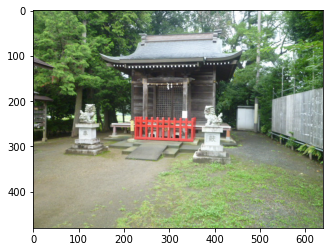

In [10]:
# テストデータで確認
# 今回学習したモデルでテスト
# モデルはGPUで学習。GPUを使って推論するときはこれでOK
#best_model = torch.load('best_model_resnet101_tl20210906.pth')
# CPUで推論するときはmap_location="CPU"を指定
best_model = torch.load('best_model_resnet101_inagi_tl20211124.pth', map_location="cpu")


# 対象画像
filename = 'inagi_dataset/P1150408.JPG'
filename = 'inagi_dataset/P1150892.JPG'

#filename = 'dataset/monument.JPG'
#filename = 'dataset/pump.JPG'
#filename = 'dataset/stone.JPG'
#filename = 'dataset/aoi-shrine.JPG'
#filename = 'dataset/Lion.jpeg'


# 読み込み画像をリサイズやtensorなどの方に変換
input_image = Image.open(filename)

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

# GPU使える場合はGPUを使う
# CPUを使うときは、コメントアウト
#if torch.cuda.is_available():
    #input_batch = input_batch.to('cuda')
    #best_model.to('cuda')

# AIの判定
with torch.no_grad():
    output = best_model(input_batch)
output = torch.nn.functional.softmax(output[0], dim=0)
print(output.shape)

# 出力結果から2種類のうちどれかを数値で取得
output = output.to('cpu').detach().numpy().copy()
ind = np.argmax(output)
print(output)
print(class_names[ind])

%matplotlib inline
 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(filename),cmap="gray")